# How to better understand incorrect predictions from a Random Forest Classifier

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_breast_cancer
from graphviz import Digraph
import copy
from collections import Counter

#### As a test case we'll use the breast cancer dataset from scikit learn

In [2]:
data = load_breast_cancer()

#### The data come with a bunch of metadata that we need to unpack into a dataframe

In [3]:
type(data)

sklearn.utils.Bunch

In [4]:
data.keys()

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename'])

In [5]:
data['target_names']

array(['malignant', 'benign'], dtype='<U9')

In [6]:
data_df = pd.DataFrame(data['data'])

In [7]:
# clean up the columns
data_df.columns = [i.replace(' ', '_') for i in data['feature_names']]

In [8]:
# add the target column to the dataset
data_df['target']=data['target']

#### The description attribute contains some useful information about the data

In [9]:
data['DESCR'].split('\n')

['.. _breast_cancer_dataset:',
 '',
 'Breast cancer wisconsin (diagnostic) dataset',
 '--------------------------------------------',
 '',
 '**Data Set Characteristics:**',
 '',
 '    :Number of Instances: 569',
 '',
 '    :Number of Attributes: 30 numeric, predictive attributes and the class',
 '',
 '    :Attribute Information:',
 '        - radius (mean of distances from center to points on the perimeter)',
 '        - texture (standard deviation of gray-scale values)',
 '        - perimeter',
 '        - area',
 '        - smoothness (local variation in radius lengths)',
 '        - compactness (perimeter^2 / area - 1.0)',
 '        - concavity (severity of concave portions of the contour)',
 '        - concave points (number of concave portions of the contour)',
 '        - symmetry ',
 '        - fractal dimension ("coastline approximation" - 1)',
 '',
 '        The mean, standard error, and "worst" or largest (mean of the three',
 '        largest values) of these features were c

#### Check what the data actually look like

In [10]:
data_df.head()

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,mean_fractal_dimension,...,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


### Prepare the data and fit model
- Split into train and test sets
- Instantiate the RF classifier
- Fit the training data
- Predict the test set

_Using `random_state` for reproducibility_

In [11]:
test = data_df.sample(frac = 0.3, random_state=181)
train = data_df.drop(test.index)

In [12]:
rf_class = RandomForestClassifier(random_state=132)

In [13]:
model = rf_class.fit(train.drop('target', axis = 1), train['target'])

#### Check to see the values of each hyperparameter

In [14]:
model

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=132,
                       verbose=0, warm_start=False)

In [15]:
test['pred'] = model.predict(test.drop('target', axis = 1))

## No model is perfect. By understanding the nature of the errors we can better identify ways to improve the model or areas where the model should not be applied.

#### We can start by seeing where the model made incorrect classifications

In [16]:
test[test['target']!=test['pred']]

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,mean_fractal_dimension,...,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension,target,pred
157,16.84,19.46,108.40,880.2,0.07445,0.07223,0.05150,0.02771,0.1844,0.05268,...,120.3,1032.0,0.08774,0.17100,0.1882,0.08436,0.2527,0.05972,1,0
363,16.50,18.29,106.60,838.1,0.09686,0.08468,0.05862,0.04835,0.1495,0.05593,...,117.2,1009.0,0.13380,0.16790,0.1663,0.09123,0.2394,0.06469,1,0
297,11.76,18.14,75.00,431.1,0.09968,0.05914,0.02685,0.03515,0.1619,0.06287,...,85.1,553.6,0.11370,0.07974,0.0612,0.07160,0.1978,0.06915,0,1
73,13.80,15.79,90.43,584.1,0.10070,0.12800,0.07789,0.05069,0.1662,0.06566,...,110.3,812.4,0.14110,0.35420,0.2779,0.13830,0.2589,0.10300,0,1
484,15.73,11.28,102.80,747.2,0.10430,0.12990,0.11910,0.06211,0.1784,0.06259,...,112.5,854.3,0.15410,0.29790,0.4004,0.14520,0.2557,0.08181,1,0


#### We can further categorize the predictions as:
 - True Positive (TP): The model correctly predicted malignant
 - True Negative (TN): The model correctly predicted benign
 - False Positive (FP): The model incorrectly predicted malignant
 - False Negative (FN): The model incorrectly predicted benign

In [17]:
test['TP'] = ((test['target']==0)&(test['pred']==0)).astype(int)
test['TN'] = ((test['target']==1)&(test['pred']==1)).astype(int)
test['FP'] = ((test['target']==1)&(test['pred']==0)).astype(int)
test['FN'] = ((test['target']==0)&(test['pred']==1)).astype(int)

In [18]:
test[test['target']!=test['pred']]

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,mean_fractal_dimension,...,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension,target,pred,TP,TN,FP,FN
157,16.84,19.46,108.40,880.2,0.07445,0.07223,0.05150,0.02771,0.1844,0.05268,...,0.1882,0.08436,0.2527,0.05972,1,0,0,0,1,0
363,16.50,18.29,106.60,838.1,0.09686,0.08468,0.05862,0.04835,0.1495,0.05593,...,0.1663,0.09123,0.2394,0.06469,1,0,0,0,1,0
297,11.76,18.14,75.00,431.1,0.09968,0.05914,0.02685,0.03515,0.1619,0.06287,...,0.0612,0.07160,0.1978,0.06915,0,1,0,0,0,1
73,13.80,15.79,90.43,584.1,0.10070,0.12800,0.07789,0.05069,0.1662,0.06566,...,0.2779,0.13830,0.2589,0.10300,0,1,0,0,0,1
484,15.73,11.28,102.80,747.2,0.10430,0.12990,0.11910,0.06211,0.1784,0.06259,...,0.4004,0.14520,0.2557,0.08181,1,0,0,0,1,0


#### In this case a  FN would be the worst case scenario, where the existance of a malignant tumor was not caught. So we will look more closely at those scenarios.

# Visualizing the Random Forest

Recall that a random forest is comprised of multiple trees. Visualizing the tree can provide useful context to the decisions made in it. One way to visualize the tree is by using scikit learn's `export_graphviz` function, which will save off a static `.dot` file:

In [19]:
from sklearn.tree import export_graphviz
from subprocess import call

export_graphviz(model.estimators_[0], out_file='test_tree.dot', 
                feature_names = data['feature_names'],
                class_names = data['target_names'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

call(['dot', '-Tpng', 'test_tree.dot', '-o', 'test_tree.png', '-Gdpi=600'])

0

#### This is useful but has limited functionality and is hard to see how points traverse the tree. The model object itself provides all the pieces we need to visualize the tree in a notebook

# Understanding RandomForestClassifier model object

Each tree, or estimator, in the random forest can be accessed using `.estimator_`

In [20]:
# number of estimators
len(model.estimators_)

100

To access a single tree object, use `.tree_` on a single item from `.estimators_` 

In [21]:
# access a single tree, the first one in this case
model.estimators_[0].tree_

The total number of nodes in a tree is stored the the `.note_count` attribute

In [22]:
# total number of nodes in tree
model.estimators_[0].tree_.node_count

29

The `.features` attribute shows what feature is considered at each node. The numbers correspond to the column index position from the original dataframe. `-2` indicates a terminal node (no feature considered)

In [23]:
# feature considered at each node, based on column position of original df
# (-2 means a terminal node, no feature considered)
model.estimators_[0].tree_.feature

array([25,  3, 27, -2, 17, 26, -2,  1, -2, -2,  1, -2,  9, -2, -2, 15,  1,
       -2, -2, -2, 23, 24, -2, -2, 21,  1, -2, -2, -2])

In [24]:
feat_names = []
for node_feat in model.estimators_[0].tree_.feature:
    if node_feat == -2:
        feat_names.append('terminal_leaf')
    else:
        feat_names.append(data_df.columns[node_feat])
feat_names

['worst_compactness',
 'mean_area',
 'worst_concave_points',
 'terminal_leaf',
 'concave_points_error',
 'worst_concavity',
 'terminal_leaf',
 'mean_texture',
 'terminal_leaf',
 'terminal_leaf',
 'mean_texture',
 'terminal_leaf',
 'mean_fractal_dimension',
 'terminal_leaf',
 'terminal_leaf',
 'compactness_error',
 'mean_texture',
 'terminal_leaf',
 'terminal_leaf',
 'terminal_leaf',
 'worst_area',
 'worst_smoothness',
 'terminal_leaf',
 'terminal_leaf',
 'worst_texture',
 'mean_texture',
 'terminal_leaf',
 'terminal_leaf',
 'terminal_leaf']

The the right branch of a given node is found using `.children_right`. The value references the index position in the `.feature` attribute

For example, in this tree, the right branch node for the first node in the tree is node `23`, because that is the node at index position `20` of the `.feature` attribute

-1 means there is no right branch, since the node is a terminal node

In [25]:
model.estimators_[0].tree_.children_right

array([20, 15,  4, -1, 10,  7, -1,  9, -1, -1, 12, -1, 14, -1, -1, 19, 18,
       -1, -1, -1, 24, 23, -1, -1, 28, 27, -1, -1, -1])

The same is true for `.children_left`

In [26]:
model.estimators_[0].tree_.children_left

array([ 1,  2,  3, -1,  5,  6, -1,  8, -1, -1, 11, -1, 13, -1, -1, 16, 17,
       -1, -1, -1, 21, 22, -1, -1, 25, 26, -1, -1, -1])

The threshold value for the considered feature is under the `.threshold` attribute

The left path is selected if the feature is `<=` the threshold, and the right if the feature is `>`

In [27]:
model.estimators_[0].tree_.threshold

array([ 2.90150002e-01,  6.98649994e+02,  9.32249986e-02, -2.00000000e+00,
        1.03850001e-02,  1.98050000e-01, -2.00000000e+00,  1.86350002e+01,
       -2.00000000e+00, -2.00000000e+00,  2.27950001e+01, -2.00000000e+00,
        5.79349995e-02, -2.00000000e+00, -2.00000000e+00,  1.31099997e-02,
        1.71199994e+01, -2.00000000e+00, -2.00000000e+00, -2.00000000e+00,
        7.36950012e+02,  2.00000003e-01, -2.00000000e+00, -2.00000000e+00,
        1.97749996e+01,  1.48850002e+01, -2.00000000e+00, -2.00000000e+00,
       -2.00000000e+00])

The impurity at each node in tree from training is in the `.impurity` attribute

This model used the default impurity value, `gini`

In [28]:
# 
model.estimators_[0].tree_.impurity

array([0.45604909, 0.22967128, 0.10049146, 0.        , 0.36556927,
       0.49905482, 0.        , 0.32      , 0.        , 0.        ,
       0.06243496, 0.        , 0.5       , 0.        , 0.        ,
       0.25240055, 0.48979592, 0.        , 0.        , 0.        ,
       0.28823381, 0.15879017, 0.        , 0.        , 0.01922896,
       0.5       , 0.        , 0.        , 0.        ])

# Constructing a tree

## Knowing the different pieces stored within the model object, we can organize them for visualizing a tree

#### First create a dictionary that gathers the information belonging to a given node

In [29]:
tree_dict = {}
single_tree = model.estimators_[0].tree_
for ind, (feat, thresh, imp, left, right) in enumerate(zip(single_tree.feature, single_tree.threshold, single_tree.impurity, single_tree.children_left, single_tree.children_right)):
    if feat != -2:
        tree_dict[ind] = {'feature': data_df.columns[feat],
                          'threshold': thresh,
                          'impurity': imp,
                          'left_node': left,
                          'right_node':right}
    else:
        tree_dict[ind] = {'feature': 'terminal_leaf',
                          'threshold': np.nan,
                          'impurity': imp,
                          'left_node': np.nan,
                          'right_node':np.nan}

#### With the `graphviz` package we can use the node information to visualize the tree

In [30]:
g = Digraph(strict=True) # this arg is important for updating edges later on

for node_id, node_data in tree_dict.items():
    g.node(str(node_id))
    if node_data['feature'] != 'terminal_leaf':
        g.node(str(node_data['left_node']))
        g.node(str(node_data['right_node']))
        g.edge(str(node_id), str(node_data['left_node']))
        g.edge(str(node_id), str(node_data['right_node']))

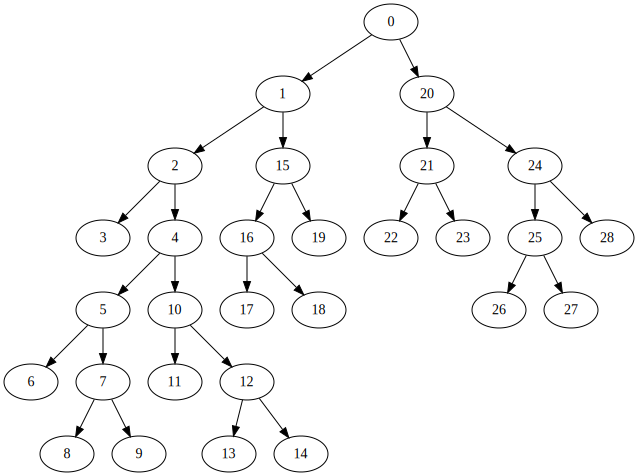

In [31]:
# the numbers inside each node refer to the index position in the model.estimators_[0].tree_.feature attribute
g

#### This output can be compared the `.dot` file made previously

# Visualizing the path through the tree

#### Now with the tree created we can add information about individual data points, such as the path a FN took through the tree to better understand why.

In [32]:
# Select a single FN
single_fn = test[test['FN']==1].head(1).reset_index(drop=True)
single_fn

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,mean_fractal_dimension,...,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension,target,pred,TP,TN,FP,FN
0,11.76,18.14,75.0,431.1,0.09968,0.05914,0.02685,0.03515,0.1619,0.06287,...,0.0612,0.0716,0.1978,0.06915,0,1,0,0,0,1


## We can now trace the FN's path through the tree

In [33]:
# make an empty list to store all the steps
fn_path = []

# start with the first node of the tree
node_id = 0 # always 0

# and add data to dict:
node_data = tree_dict[node_id]
node_data.update({'node_id': node_id, 'value': single_fn[node_data['feature']].values[0]})
fn_path.append(copy.deepcopy(node_data)) # to ensure values don't get overwritten

feat = fn_path[-1]['feature']

# traverse the tree until encounter a termainal leaf
while feat != 'terminal_leaf':
    # determine if should follow left or right path
    if fn_path[-1]['value'] <= fn_path[-1]['threshold']:
        fn_path[-1]['comparison'] = '<='
        node_id = fn_path[-1]['left_node']
    elif fn_path[-1]['value'] > fn_path[-1]['threshold']:
        fn_path[-1]['comparison'] = '>'
        node_id = fn_path[-1]['right_node']
    else:
        print('something went wrong')
        break
    node_data = tree_dict[node_id]
    try:
        node_data.update({'node_id': node_id, 'value': single_fn[node_data['feature']].values[0]})
    except KeyError:
        node_data.update({'node_id': node_id, 'value': np.nan})
    fn_path.append(copy.deepcopy(node_data))
    feat = fn_path[-1]['feature']
    

#### With the path created, we can highlight it on the tree

In [34]:
for step in fn_path[:-1]:
    if step['comparison'] == '<=':
        g.edge(str(step['node_id']), str(step['left_node']), color = 'red')
    else:
        g.edge(str(step['node_id']), str(step['right_node']), color = 'red')

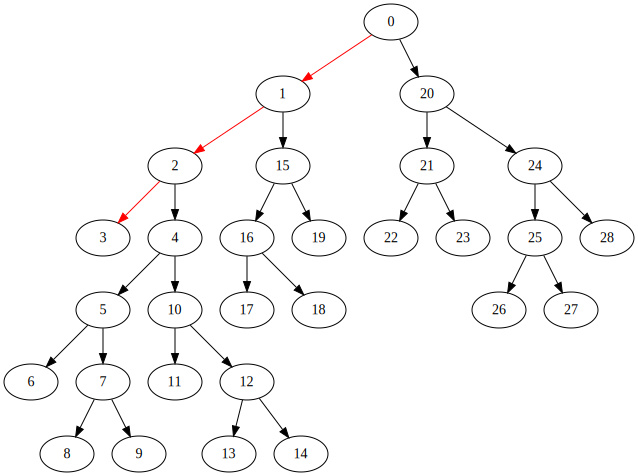

In [35]:
g

#### We can compare this with other TPs to see where this data point may have diverged from others

In [36]:
ten_tp = test[test['TP']==1].head(10).reset_index(drop=True)

In [37]:
ten_tp

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,mean_fractal_dimension,...,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension,target,pred,TP,TN,FP,FN
0,15.46,19.48,101.70,748.9,0.10920,0.12230,0.14660,0.08087,0.1931,0.05796,...,0.3791,0.15140,0.2837,0.08019,0,0,1,0,0,0
1,12.83,22.33,85.26,503.2,0.10880,0.17990,0.16950,0.06861,0.2123,0.07254,...,0.6282,0.19770,0.3407,0.12430,0,0,1,0,0,0
2,20.18,23.97,143.70,1245.0,0.12860,0.34540,0.37540,0.16040,0.2906,0.08142,...,0.7681,0.25080,0.5440,0.09964,0,0,1,0,0,0
3,15.85,23.95,103.70,782.7,0.08401,0.10020,0.09938,0.05364,0.1847,0.05338,...,0.2322,0.11190,0.2809,0.06287,0,0,1,0,0,0
4,16.69,20.20,107.10,857.6,0.07497,0.07112,0.03649,0.02307,0.1846,0.05325,...,0.2477,0.08737,0.4677,0.07623,0,0,1,0,0,0
5,15.78,22.91,105.70,782.6,0.11550,0.17520,0.21330,0.09479,0.2096,0.07331,...,0.7356,0.20340,0.3274,0.12520,0,0,1,0,0,0
6,20.44,21.78,133.80,1293.0,0.09150,0.11310,0.09799,0.07785,0.1618,0.05557,...,0.2702,0.17650,0.2609,0.06735,0,0,1,0,0,0
7,19.53,18.90,129.50,1217.0,0.11500,0.16420,0.21970,0.10620,0.1792,0.06552,...,0.6121,0.19800,0.2968,0.09929,0,0,1,0,0,0
8,14.58,21.53,97.41,644.8,0.10540,0.18680,0.14250,0.08783,0.2252,0.06924,...,0.5539,0.27010,0.4264,0.12750,0,0,1,0,0,0
9,13.61,24.69,87.76,572.6,0.09258,0.07862,0.05285,0.03085,0.1761,0.06130,...,0.3796,0.13290,0.3470,0.07900,0,0,1,0,0,0


In [38]:
def find_path(tree_dict, point_series):
    path = []
    node_id = 0
    
    node_data = tree_dict[node_id]
    node_data.update({'node_id': node_id, 'value': point_series[node_data['feature']]}) # Need to add node_id for visualization purposes
    
    feat = node_data['feature']

    while feat != 'terminal_leaf':
        if node_data['value'] <= node_data['threshold']:
            node_data['comparison'] = '<='
            path.append(copy.deepcopy(node_data))
            node_id = node_data['left_node']
        elif node_data['value'] > node_data['threshold']:
            node_data['comparison'] = '>'
            path.append(copy.deepcopy(node_data))
            node_id = node_data['right_node']
        else:
            print('something went wrong')
            break
        node_data = tree_dict[node_id]
        node_data['node_id'] = node_id
        try:
            node_data.update({'node_id': node_id, 'value': point_series[node_data['feature']]})
        except KeyError:
            node_data.update({'node_id': node_id, 'value': np.nan})
        feat = node_data['feature']
    path.append(copy.deepcopy(node_data))
    return path

In [39]:
tp_paths = [find_path(tree_dict, row) for ind, row in ten_tp.iterrows()]

In [40]:
# Increases thickness of line based on the number of points that take a certain step
def adjust_edge_width(edge_counter, top_node, bottom_node):
    try:
        edge_counter[(top_node, bottom_node)] += 1
    except KeyError:
        edge_counter[(top_node, bottom_node)] = 1
    return edge_counter

In [41]:
edge_counter = {}
for path in tp_paths:
    for step in path[:-1]:
        try:
            if step['comparison'] == '<=':
                edge_counter = adjust_edge_width(edge_counter, step['node_id'], step['left_node'])
                g.edge(str(step['node_id']), str(step['left_node']), color = 'blue', penwidth = str(min(5, edge_counter[(step['node_id'], step['left_node'])])))
            else:
                edge_counter = adjust_edge_width(edge_counter, step['node_id'], step['right_node'])
                g.edge(str(step['node_id']), str(step['right_node']), color = 'blue', penwidth = str(min(5, edge_counter[(step['node_id'], step['right_node'])])))
        except KeyError:
            continue

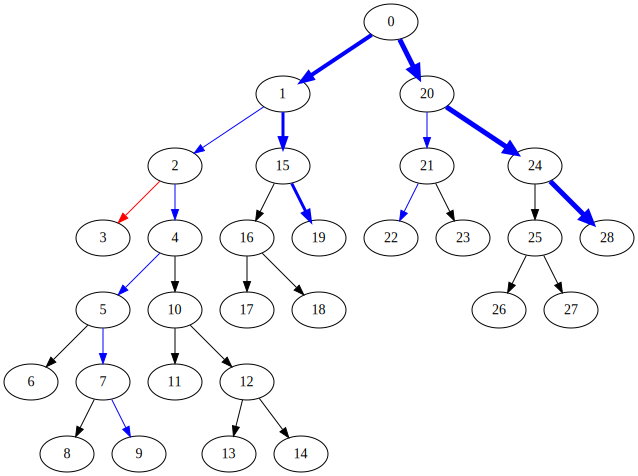

In [42]:
g

#### In the above example the divergence point was node 2, which we can see what feature and threshold was considered at that node by accessing the tree_dict

In [43]:
tree_dict[2]

{'feature': 'worst_concave_points',
 'threshold': 0.09322499856352806,
 'impurity': 0.10049146189087876,
 'left_node': 3,
 'right_node': 4,
 'node_id': 2,
 'value': 0.1329,
 'comparison': '>'}

#### We can see that 'worst_concave_points' was considered and the threshold was 0.09322499856352806. This feature/threshold _could_ warrant some further investigation but lets add the rest of the FNs and TPs and get a better picture

In [44]:
fn_paths = [find_path(tree_dict, row) for ind, row in test[test['FN']==1].reset_index(drop=True).iterrows()]

In [45]:
tp_paths = [find_path(tree_dict, row) for ind, row in test[test['TP']==1].reset_index(drop=True).iterrows()]

In [46]:
def add_paths(df, color, g):
    edge_counter = {}
    for path in df:
        for step in path[:-1]:
            try:
                if step['comparison'] == '<=':
                    edge_counter = adjust_edge_width(edge_counter, step['node_id'], step['left_node'])
                    g.edge(str(step['node_id']), str(step['left_node']), color = color, penwidth = str(min(5, edge_counter[(step['node_id'], step['left_node'])])))
                else:
                    edge_counter = adjust_edge_width(edge_counter, step['node_id'], step['right_node'])
                    g.edge(str(step['node_id']), str(step['right_node']), color = color, penwidth = str(min(5, edge_counter[(step['node_id'], step['right_node'])])))
            except KeyError:
                continue
    return g

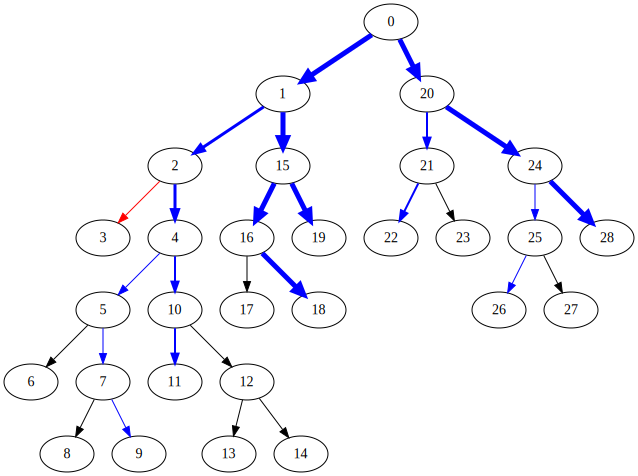

In [47]:
g = add_paths(fn_paths, 'red', g)
g = add_paths(tp_paths, 'blue', g)
g

#### We still see 2 as a divergence point, but it looks like only 1 of the 2 FNs is captured. The other FN seems to be following the same path as a TP. Why is that?

#### Remember that a random forest includes multiple trees (100 in this case). The final prediction is based on all the trees. For this specific tree it correctly predicted one of the overall FNs and incorrectly the other.

#### To better capture the comprehensive picture of model performance, we would have to expand to all trees. Furthermore, we need to compare where FNs diverge from TPs and compare that to where TPs diverge from each other.

# Find divergence points

In [48]:
# Make pairwise combinations of each FN and TP
combos = [[f, t] for f in fn_paths for t in tp_paths]

In [49]:
# Do the dame for each TP for comparison
combos_tp = [[t_1, t_2] for t_1 in tp_paths for t_2 in tp_paths]

In [50]:
def find_divergence_features(combos):
    divergence_feats = []
    for ind, c in enumerate(combos):
        c = list(zip(*c))
        for ind, (f, t) in enumerate(c):
            if f['feature'] != t['feature']:
                divergence_feats.append(c[ind-1][0]['feature'])
    return divergence_feats

## Now we can compare the divergence points between FNs and TPs as well as between TPs

In [51]:
divergence_feats = find_divergence_features(combos)
sorted(Counter(divergence_feats).items(), key=lambda x: x[1], reverse=True)

[('worst_compactness', 59),
 ('mean_area', 56),
 ('worst_area', 27),
 ('worst_concave_points', 9),
 ('worst_texture', 9)]

In [52]:
divergence_feats_tp = find_divergence_features(combos_tp)
sorted(Counter(divergence_feats_tp).items(), key=lambda x: x[1], reverse=True)

[('worst_compactness', 1700),
 ('mean_area', 982),
 ('worst_area', 978),
 ('compactness_error', 418),
 ('worst_texture', 332),
 ('worst_concave_points', 168),
 ('concave_points_error', 22),
 ('mean_texture', 20),
 ('worst_smoothness', 18),
 ('worst_concavity', 2)]

#### Aside from `compactness_error`, the divergence features between FNs and TPs are also the top features between TPs. Lets dig deeper to see if we can gain more understanding about what could differentiate FNs from TPs

In [53]:
def calc_divergence_difference(combos):
    divergence_feat_dif = {}
    for ind, c in enumerate(combos):
        c = list(zip(*c))
        for ind, (f, t) in enumerate(c):
            if f['feature'] != t['feature']:
                try:
                    divergence_feat_dif[c[ind-1][0]['feature']].append(c[ind-1][0]['value'] - c[ind-1][1]['value'])
                except:
                    divergence_feat_dif[c[ind-1][0]['feature']] = [c[ind-1][0]['value'] - c[ind-1][1]['value']]
    return divergence_feat_dif

In [54]:
divergence_feat_fn_diff = calc_divergence_difference(combos)
for k, v in divergence_feat_fn_diff.items():
    divergence_feat_fn_diff[k] = np.mean(v)

In [55]:
divergence_feat_tp_diff = calc_divergence_difference(combos_tp)
for k, v in divergence_feat_tp_diff.items():
    divergence_feat_tp_diff[k] = np.mean(v)

Put the data in a dataframe to make it easier to compare divergence differences

In [56]:
tp_div_df = pd.DataFrame(divergence_feat_tp_diff, index = ["tp"]).T
fn_div_df = pd.DataFrame(divergence_feat_fn_diff, index = ["fn"]).T
compare_tp_div_df = pd.merge(fn_div_df, tp_div_df, how = 'left', left_index = True, right_index = True)
compare_tp_div_df

,fn,tp
mean_area,-999.517857,-4.378175e+02
worst_compactness,-0.147180,-4.179663e-18
worst_concave_points,-1.879137,-1.703730e+01
worst_area,-257.359259,4.396082e+02
worst_texture,18.909263,2.384396e+01


Here we can see some differences between branch points. When FNs diverge from TPs, the difference between the values considered at that point are, on average, more extreme than when TPs diverge from each other. This gives us a place to start looking at where the model is not fully able to model the training data.

 should record exact node and _ideally_ the entire path that led to the divergence